# EASE & ItemKNN with Globo Dataset and StrongGeneralization & TimedLastItemPrediction Scenario

In this notebook, the experiment of EASE & ItemKNN in RecPack will be presented. 
The notebook contains:

1. The 10% of Globo Dataset from RecPack.
2. The StrongGeneralization & TimedLastItemPrediction Scenario to split the data.
3. The RecPack Pipeline Builder to run the experiments, including the splitted dataset, the algorithms and metrics to run. Hyperparameter has been performed in the Pipeline.

Please make sure you have installed all the latest libraries in your Python environment, in order to have a successful run of the code.

In [2]:
from recpack.datasets import Netflix, DummyDataset
from recpack.pipelines import PipelineBuilder
from recpack.scenarios import StrongGeneralization, TimedLastItemPrediction, WeakGeneralization
from recpack.pipelines import ALGORITHM_REGISTRY
import pandas as pd

In [3]:
from recpack.datasets import Globo
dataset = Globo(path="", filename="archive.zip")

In [4]:
dataset.fetch_dataset()

In [5]:
dataset

In [ ]:
df = dataset._load_dataframe()
#df = dataset.load()

## Datasets with Timestamps sampling

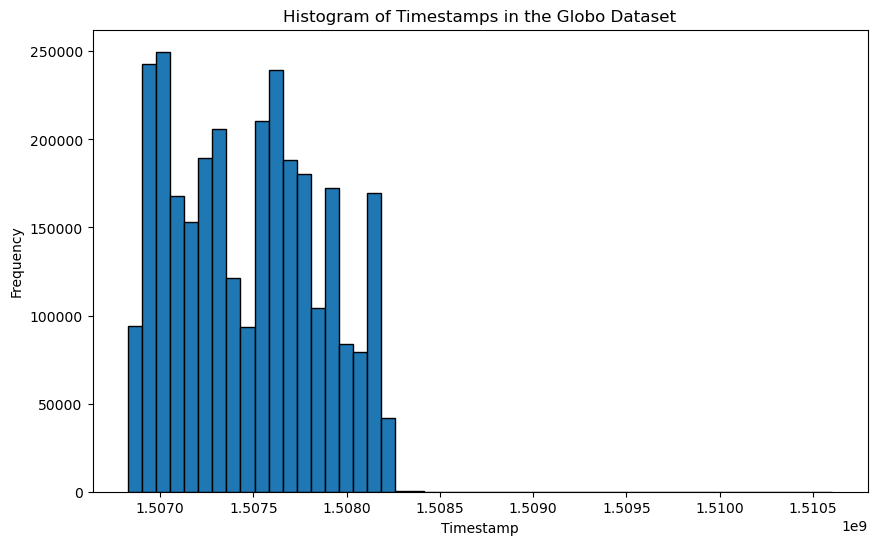

In [8]:
import matplotlib.pyplot as plt
# Plot histogram of the timestamp column
plt.figure(figsize=(10, 6))
plt.hist(df['click_timestamp'], bins=50, edgecolor='k')
plt.title('Histogram of Timestamps in the Globo Dataset')
plt.xlabel('Timestamp')
plt.ylabel('Frequency')
plt.show()

In [7]:
timestamp_counts = df['click_timestamp'].value_counts().sort_index(ascending=False)
cumulative_counts = timestamp_counts.cumsum()
total_counts = cumulative_counts.max()
threshold_count = total_counts * 0.1
threshold_timestamp = cumulative_counts[cumulative_counts >= threshold_count].index[0]

In [8]:
filtered_df = df[df['click_timestamp'] >= threshold_timestamp]

In [9]:
df

,user_id,click_article_id,click_timestamp
0,0,157541,1.506827e+09
1,0,68866,1.506827e+09
2,1,235840,1.506827e+09
3,1,96663,1.506827e+09
4,2,119592,1.506827e+09
...,...,...,...
2564,10051,84911,1.508212e+09
2565,322896,30760,1.508212e+09
2566,322896,157507,1.508212e+09
2567,123718,234481,1.508212e+09


In [10]:
filtered_df

,user_id,click_article_id,click_timestamp
4289,22712,158772,1.508196e+09
4290,22712,284638,1.508633e+09
4291,22712,95633,1.508678e+09
4292,22712,95524,1.508679e+09
4293,22712,184427,1.508679e+09
...,...,...,...
2564,10051,84911,1.508212e+09
2565,322896,30760,1.508212e+09
2566,322896,157507,1.508212e+09
2567,123718,234481,1.508212e+09


In [11]:
from recpack.matrix import InteractionMatrix
from recpack.preprocessing.preprocessors import DataFramePreprocessor

item_ix = 'click_article_id'
user_ix = 'user_id'
timestamp_ix = 'click_timestamp'

preprocessor = DataFramePreprocessor(item_ix=item_ix, user_ix=user_ix, timestamp_ix=timestamp_ix)

interaction_matrix = preprocessor.process(filtered_df)

  0%|          | 0/298819 [00:00<?, ?it/s]

  0%|          | 0/298819 [00:00<?, ?it/s]

In [15]:
interaction_matrix.timestamps.values
t_80 = interaction_matrix.timestamps.values[int(0.7 * len(interaction_matrix.timestamps.values))]
t_validate_80 = interaction_matrix.timestamps.values[int(0.7 * 0.7 * len(interaction_matrix.timestamps.values))]
print(t_80, t_validate_80)

1508169181.841 1508153035.383


In [ ]:
#The last scenario being used is TimedLastItemPrediction after generating the results of StrongGeneralization scenario
#scenario = StrongGeneralization(frac_users_train=0.75, frac_interactions_in=0.8, validation=True)
scenario = TimedLastItemPrediction(t = t_80, t_validation = t_validate_80, validation=True)
scenario.split(interaction_matrix)

In [17]:
pipeline_builder = PipelineBuilder()
ok = (scenario._validation_data_in, scenario._validation_data_out)
pipeline_builder.set_data_from_scenario(scenario)


# Add the baseline algorithms
pipeline_builder.add_algorithm('ItemKNN', grid={'K': [100, 200, 400, 800]})
pipeline_builder.add_algorithm('EASE', grid={'l2': [10, 100, 1000], 'alpha': [0, 0.1, 0.5]})


# Add NDCG, Recall, and HR metrics to be evaluated at 10, 20, and 50
pipeline_builder.add_metric('NDCGK', [10, 20, 50])
pipeline_builder.add_metric('RecallK', [10, 20, 50])
pipeline_builder.add_metric('HitK', [10, 20, 50])

# Set the optimisation metric
pipeline_builder.set_optimisation_metric('RecallK', 20)

# Construct pipeline
pipeline = pipeline_builder.build()

# Debugging: Output the shape of the training data
#print(f"Training data shape: {im.shape}")

# Run pipeline, will first do optimisation, and then evaluation
pipeline.run()

/opt/conda/lib/python3.11/site-packages/recpack/pipelines/pipeline_builder.py:145: UserWarning: Grid parameter for add_algorithm function will be deprecated in favour of optimisation_info.
  warnings.warn(


  0%|          | 0/2 [00:00<?, ?it/s]

2024-08-07 19:06:38,958 - base - recpack - INFO - Fitting ItemKNN complete - Took 0.355s


/opt/conda/lib/python3.11/site-packages/recpack/algorithms/base.py:279: UserWarning: ItemKNN missing similar items for 4888 items.
  warnings.warn(f"{self.name} missing similar items for {missing} items.")
/opt/conda/lib/python3.11/site-packages/recpack/algorithms/base.py:127: UserWarning: ItemKNN failed to recommend any items for 665 users
  warnings.warn(f"{self.name} failed to recommend any items " f"for {len(missing)} users")


2024-08-07 19:06:40,745 - base - recpack - INFO - Fitting ItemKNN complete - Took 0.385s


/opt/conda/lib/python3.11/site-packages/recpack/algorithms/base.py:279: UserWarning: ItemKNN missing similar items for 4888 items.
  warnings.warn(f"{self.name} missing similar items for {missing} items.")
/opt/conda/lib/python3.11/site-packages/recpack/algorithms/base.py:127: UserWarning: ItemKNN failed to recommend any items for 665 users
  warnings.warn(f"{self.name} failed to recommend any items " f"for {len(missing)} users")


2024-08-07 19:06:43,156 - base - recpack - INFO - Fitting ItemKNN complete - Took 0.446s


/opt/conda/lib/python3.11/site-packages/recpack/algorithms/base.py:279: UserWarning: ItemKNN missing similar items for 4888 items.
  warnings.warn(f"{self.name} missing similar items for {missing} items.")
/opt/conda/lib/python3.11/site-packages/recpack/algorithms/base.py:127: UserWarning: ItemKNN failed to recommend any items for 665 users
  warnings.warn(f"{self.name} failed to recommend any items " f"for {len(missing)} users")


2024-08-07 19:06:46,422 - base - recpack - INFO - Fitting ItemKNN complete - Took 0.459s


/opt/conda/lib/python3.11/site-packages/recpack/algorithms/base.py:279: UserWarning: ItemKNN missing similar items for 4888 items.
  warnings.warn(f"{self.name} missing similar items for {missing} items.")
/opt/conda/lib/python3.11/site-packages/recpack/algorithms/base.py:127: UserWarning: ItemKNN failed to recommend any items for 665 users
  warnings.warn(f"{self.name} failed to recommend any items " f"for {len(missing)} users")


2024-08-07 19:06:50,850 - base - recpack - INFO - Fitting ItemKNN complete - Took 0.55s


/opt/conda/lib/python3.11/site-packages/recpack/algorithms/base.py:279: UserWarning: ItemKNN missing similar items for 3228 items.
  warnings.warn(f"{self.name} missing similar items for {missing} items.")
/opt/conda/lib/python3.11/site-packages/recpack/algorithms/base.py:127: UserWarning: ItemKNN failed to recommend any items for 1858 users
  warnings.warn(f"{self.name} failed to recommend any items " f"for {len(missing)} users")


2024-08-07 19:07:42,496 - base - recpack - INFO - Fitting EASE complete - Took 34.4s


/opt/conda/lib/python3.11/site-packages/recpack/algorithms/base.py:279: UserWarning: EASE missing similar items for 4888 items.
  warnings.warn(f"{self.name} missing similar items for {missing} items.")
/opt/conda/lib/python3.11/site-packages/recpack/algorithms/base.py:127: UserWarning: EASE failed to recommend any items for 665 users
  warnings.warn(f"{self.name} failed to recommend any items " f"for {len(missing)} users")


2024-08-07 19:09:00,191 - base - recpack - INFO - Fitting EASE complete - Took 38.5s


/opt/conda/lib/python3.11/site-packages/recpack/algorithms/base.py:279: UserWarning: EASE missing similar items for 4888 items.
  warnings.warn(f"{self.name} missing similar items for {missing} items.")
/opt/conda/lib/python3.11/site-packages/recpack/algorithms/base.py:127: UserWarning: EASE failed to recommend any items for 665 users
  warnings.warn(f"{self.name} failed to recommend any items " f"for {len(missing)} users")


2024-08-07 19:10:04,846 - base - recpack - INFO - Fitting EASE complete - Took 33.2s


/opt/conda/lib/python3.11/site-packages/recpack/algorithms/base.py:279: UserWarning: EASE missing similar items for 4888 items.
  warnings.warn(f"{self.name} missing similar items for {missing} items.")
/opt/conda/lib/python3.11/site-packages/recpack/algorithms/base.py:127: UserWarning: EASE failed to recommend any items for 665 users
  warnings.warn(f"{self.name} failed to recommend any items " f"for {len(missing)} users")
/opt/conda/lib/python3.11/site-packages/recpack/algorithms/ease.py:89: RuntimeWarning: divide by zero encountered in divide
  w = 1 / np.diag(XTX) ** self.alpha
/opt/conda/lib/python3.11/site-packages/recpack/algorithms/ease.py:90: RuntimeWarning: invalid value encountered in matmul
  B = B @ np.diag(w)


2024-08-07 19:11:41,628 - base - recpack - INFO - Fitting EASE complete - Took 65.0s


/opt/conda/lib/python3.11/site-packages/recpack/algorithms/ease.py:89: RuntimeWarning: divide by zero encountered in divide
  w = 1 / np.diag(XTX) ** self.alpha
/opt/conda/lib/python3.11/site-packages/recpack/algorithms/ease.py:90: RuntimeWarning: invalid value encountered in matmul
  B = B @ np.diag(w)


2024-08-07 19:14:21,278 - base - recpack - INFO - Fitting EASE complete - Took 60.3s


/opt/conda/lib/python3.11/site-packages/recpack/algorithms/ease.py:89: RuntimeWarning: divide by zero encountered in divide
  w = 1 / np.diag(XTX) ** self.alpha
/opt/conda/lib/python3.11/site-packages/recpack/algorithms/ease.py:90: RuntimeWarning: invalid value encountered in matmul
  B = B @ np.diag(w)


2024-08-07 19:16:55,229 - base - recpack - INFO - Fitting EASE complete - Took 57.7s


/opt/conda/lib/python3.11/site-packages/recpack/algorithms/ease.py:89: RuntimeWarning: divide by zero encountered in divide
  w = 1 / np.diag(XTX) ** self.alpha
/opt/conda/lib/python3.11/site-packages/recpack/algorithms/ease.py:90: RuntimeWarning: invalid value encountered in matmul
  B = B @ np.diag(w)


2024-08-07 19:19:35,762 - base - recpack - INFO - Fitting EASE complete - Took 62.0s


/opt/conda/lib/python3.11/site-packages/recpack/algorithms/ease.py:89: RuntimeWarning: divide by zero encountered in divide
  w = 1 / np.diag(XTX) ** self.alpha
/opt/conda/lib/python3.11/site-packages/recpack/algorithms/ease.py:90: RuntimeWarning: invalid value encountered in matmul
  B = B @ np.diag(w)


2024-08-07 19:22:19,166 - base - recpack - INFO - Fitting EASE complete - Took 68.3s


/opt/conda/lib/python3.11/site-packages/recpack/algorithms/ease.py:89: RuntimeWarning: divide by zero encountered in divide
  w = 1 / np.diag(XTX) ** self.alpha
/opt/conda/lib/python3.11/site-packages/recpack/algorithms/ease.py:90: RuntimeWarning: invalid value encountered in matmul
  B = B @ np.diag(w)


2024-08-07 19:24:51,890 - base - recpack - INFO - Fitting EASE complete - Took 58.4s
2024-08-07 19:27:08,613 - base - recpack - INFO - Fitting EASE complete - Took 45.5s


/opt/conda/lib/python3.11/site-packages/recpack/algorithms/base.py:279: UserWarning: EASE missing similar items for 3228 items.
  warnings.warn(f"{self.name} missing similar items for {missing} items.")
/opt/conda/lib/python3.11/site-packages/recpack/algorithms/base.py:127: UserWarning: EASE failed to recommend any items for 1858 users
  warnings.warn(f"{self.name} failed to recommend any items " f"for {len(missing)} users")


In [18]:
pipeline.get_metrics()

,NDCGK_10,NDCGK_20,NDCGK_50,RecallK_10,RecallK_20,RecallK_50,HitK_10,HitK_20,HitK_50
"ItemKNN(K=400,normalize_X=False,normalize_sim=False,pop_discount=None,similarity=cosine)",0.132201,0.145572,0.156253,0.237551,0.291033,0.344641,0.237551,0.291033,0.344641
"EASE(alpha=0,density=None,l2=1000)",0.133219,0.146266,0.158669,0.239756,0.290844,0.352830,0.239756,0.290844,0.352830
